In [1]:
# Enable interactive figures in Jupyter Notebook
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.ticker as ticker
from scipy.linalg import rq

np.set_printoptions(suppress=True)


In [2]:
def create_rotation_matrix(yaw, pitch, roll):
    # Convert angles to radians
    yaw = np.radians(yaw)
    pitch = np.radians(pitch)
    roll = np.radians(roll)
    # Yaw matrix around Y axis
    R_yaw = np.array([
        [np.cos(yaw), 0, np.sin(yaw)],
        [0, 1, 0],
        [-np.sin(yaw), 0, np.cos(yaw)]
    ])
    # Pitch matrix around X axis
    R_pitch = np.array([
        [1, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch)],
        [0, np.sin(pitch), np.cos(pitch)]
    ])
    # Roll matrix around Z axis
    R_roll = np.array([
        [np.cos(roll), -np.sin(roll), 0],
        [np.sin(roll), np.cos(roll), 0],
        [0, 0, 1]
    ])
    # Combine the matrices
    R_combined = R_roll.dot(R_pitch).dot(R_yaw)
    return R_combined

In [3]:
def createGTCameraParameters(focal_length_x, focal_length_y, principal_point_x, principal_point_y, R, camera_translation_vector_from_world_origin):
    # Construct a 4x4 extrinsic matrix
    extrinsic_matrix = np.eye(4)
    extrinsic_matrix[:3, :3] = R  # Rotation
    extrinsic_matrix[:3, 3] = -R @ camera_translation_vector_from_world_origin  # Translation
    
    # Construct the intrinsic matrix (3x4)
    K = np.array([[focal_length_x, 0, principal_point_x, 0],
                  [0, focal_length_y, principal_point_y, 0],
                  [0, 0, 1, 0]])
    
    # Camera projection matrix P = K * [R|t]
    P = np.dot(K, extrinsic_matrix)
    
    print("\nCamera Center in World Coordinates:")
    print(camera_translation_vector_from_world_origin)
    print("\nCamera Translation Vector (t):")
    print(extrinsic_matrix[:3, 3])
    print("\nCamera Rotation Matrix (R):")
    print(R)
    print("\nExtrinsic Matrix [R|t]:")
    print(extrinsic_matrix)
    print("\nIntrinsic Matrix (K):")
    print(K)
    print("\nCamera Projection Matrix (P):")
    print(P)

    return P, extrinsic_matrix, K

In [4]:
def project_world_to_camera(points_3d, P, image_width, image_height):
    # Convert 3D points to homogeneous coordinates
    points_3d_homogeneous = np.column_stack((points_3d, np.ones((points_3d.shape[0], 1))))
    # Project the points using P
    points_2d_homogeneous = np.dot(P, points_3d_homogeneous.T).T
    # Normalize homogeneous coordinates
    points_2d_normalized = points_2d_homogeneous[:, :2] / points_2d_homogeneous[:, 2:]
    # Check if points are within the image boundaries (not used for error computation)
    points_inside_frame = np.logical_and.reduce((
        points_2d_normalized[:, 0] >= 0,
        points_2d_normalized[:, 0] <= image_width,  # image width
        points_2d_normalized[:, 1] >= 0,
        points_2d_normalized[:, 1] <= image_height   # image height
    ))
    return points_2d_normalized, points_inside_frame

In [5]:
def plotWorldPoints(ax, points, rotation_matrix, camera_origin):
    num_points = len(points)
    # Pre-generate(fix) colors for consistency
    np.random.seed(0)
    colors = np.random.rand(num_points, 3)
    for i in range(num_points):
        ax.scatter(points[i, 0], points[i, 1], points[i, 2], c=[colors[i]], marker='o', s=50)
        ax.text(points[i, 0], points[i, 1], points[i, 2], f'{i+1}', color='black', fontsize=10)
    
    # Plot a red cross at the world origin
    ax.plot([0], [0], [0], marker='x', markersize=10, color='red')
    
    # Plot world coordinate axes
    world_axes_length = 1.0
    ax.plot([0, world_axes_length], [0, 0], [0, 0], color='green', label='World X')
    ax.plot([0, 0], [0, world_axes_length], [0, 0], color='orange', label='World Y')
    ax.plot([0, 0], [0, 0], [0, 3], color='purple', label='World Z')
    
    # Label the world axes
    ax.text(world_axes_length, 0, 0, 'X', color='green', fontsize=12)
    ax.text(0, world_axes_length, 0, 'Y', color='orange', fontsize=12)
    ax.text(0, 0, 3, 'Z', color='purple', fontsize=12)
    
    # Plot the camera origin and coordinate axes
    ax.plot([camera_origin[0]], [camera_origin[1]], [camera_origin[2]], marker='x', markersize=10, color='blue')
    camera_axes_length = 1.0
    camera_x_axis = rotation_matrix[:, 0] * camera_axes_length + camera_origin
    camera_y_axis = rotation_matrix[:, 1] * camera_axes_length + camera_origin
    camera_z_axis = rotation_matrix[:, 2] * 3 + camera_origin
    ax.plot([camera_origin[0], camera_x_axis[0]], [camera_origin[1], camera_x_axis[1]], [camera_origin[2], camera_x_axis[2]], color='blue', label='Camera X')
    ax.plot([camera_origin[0], camera_y_axis[0]], [camera_origin[1], camera_y_axis[1]], [camera_origin[2], camera_y_axis[2]], color='cyan', label='Camera Y')
    ax.plot([camera_origin[0], camera_z_axis[0]], [camera_origin[1], camera_z_axis[1]], [camera_origin[2], camera_z_axis[2]], color='magenta', label='Camera Z')
    ax.text(camera_x_axis[0], camera_x_axis[1], camera_x_axis[2], 'X', color='blue', fontsize=12)
    ax.text(camera_y_axis[0], camera_y_axis[1], camera_y_axis[2], 'Y', color='cyan', fontsize=12)
    ax.text(camera_z_axis[0], camera_z_axis[1], camera_z_axis[2], 'Z', color='magenta', fontsize=12)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper left')

    ax.grid(True)

In [6]:
def plotImagePixelPoints(ax, image_points, image_width=640, image_height=480):
    num_points = len(image_points)
    # Pre-generate(fix) colors for consistency
    np.random.seed(0)
    colors = np.random.rand(num_points, 3)
    # Invert y-coordinates for image coordinate system (origin at top-left)
    image_points[:, 1] = -image_points[:, 1]
    ax.plot([0], [0], marker='x', markersize=10, color='red')
    for i in range(num_points):
        ax.scatter(image_points[i, 0], image_points[i, 1], c=[colors[i]], marker='o', s=50)
        ax.text(image_points[i, 0], image_points[i, 1], f'{i+1}', color='black', fontsize=10)
    ax.set_xlabel('U (pixels)')
    ax.set_ylabel('V (pixels)')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{abs(x):0.0f}'))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{abs(y):0.0f}'))
    ax.set_xlim(0, image_width)
    ax.set_ylim(-image_height, 0)
    ax.grid(True)

### --------------------------
### Task-1 Implementation with Interactive 3D Plot
### --------------------------

In [7]:
# GT Intrinsic parameters (in pixels)
focal_length_x = 800.0 
focal_length_y = 700.0
principal_point_x = 320.0
principal_point_y = 240.0
image_width = 640
image_height = 480

# GT Extrinsic parameters (in degrees and meters)
camera_yaw = 3     # small rotation around Y axis
camera_pitch = 2   # small rotation around X axis
camera_roll = 5    # small rotation around Z axis

# Camera translation (in meters)
camera_translation_vector_from_world_origin = np.array([2, 2, 12], dtype=np.float32)

# Non-coplanar 3D points (provided)
world_3D_points = np.array([[1.0, 1.0, 1.0],
                            [1.0, 2.0, 2.0],
                            [1.0, 3.0, 3.0],
                            [2.0, 1.0, 4.0],
                            [2.0, 2.0, 5.0],
                            [2.0, 3.0, 6.0],
                            [2.0, 4.0, 2.5],
                            [2.5, 1.0, 8.0],
                            [2.5, 2.0, 9.0],
                            [2.5, 3.0, 5.5]], dtype=np.float32)


Camera Center in World Coordinates:
[ 2.  2. 12.]

Camera Translation Vector (t):
[ 1.53940331 -2.23576435 12.02628767]

Camera Rotation Matrix (R):
[[-0.99467026 -0.08885585  0.05230407]
 [-0.08710265  0.99558784  0.0348995 ]
 [-0.05517433  0.03015767 -0.9980212 ]]

Extrinsic Matrix [R|t]:
[[-0.99467026 -0.08885585  0.05230407  1.53940331]
 [-0.08710265  0.99558784  0.0348995  -2.23576435]
 [-0.05517433  0.03015767 -0.9980212  12.02628767]
 [ 0.          0.          0.          1.        ]]

Intrinsic Matrix (K):
[[800.   0. 320.   0.]
 [  0. 700. 240.   0.]
 [  0.   0.   1.   0.]]

Camera Projection Matrix (P):
[[-813.39199048  -61.43422386 -277.52352325 5079.93470764]
 [ -74.21369291  704.14933053 -215.0954395  1321.27399874]
 [  -0.05517433    0.03015767   -0.9980212    12.02628767]]


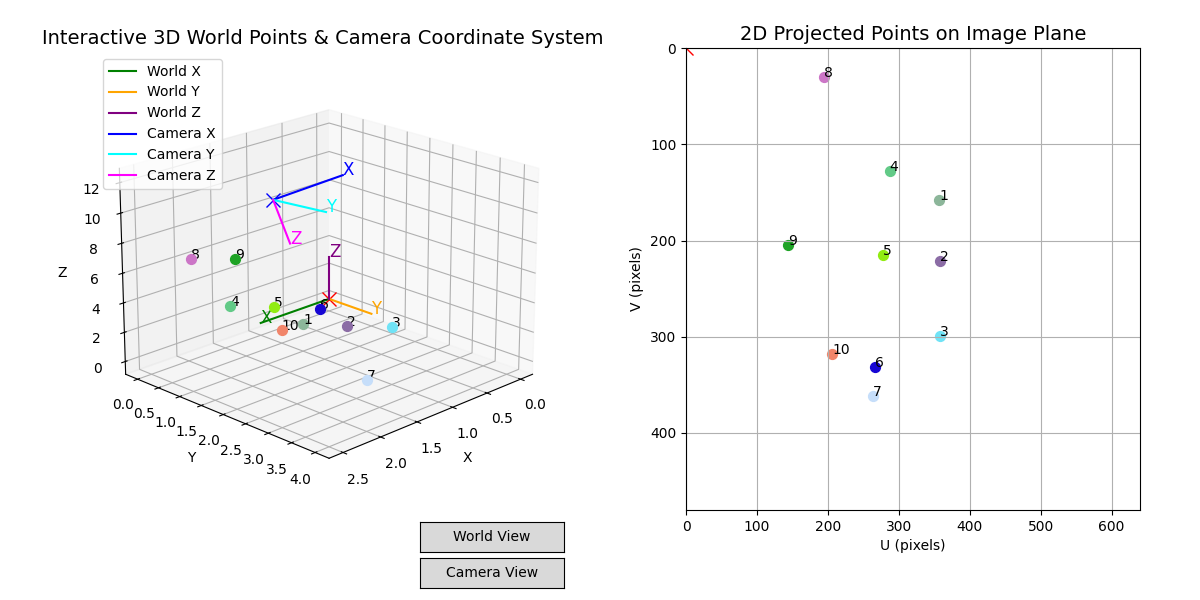

In [8]:
# Create camera rotation matrix from Euler angles
camera_rotation_matrix = create_rotation_matrix(camera_yaw, camera_pitch, camera_roll)
# Invert X and Z axes for the desired camera coordinate system
camera_rotation_matrix[:, 0] = -camera_rotation_matrix[:, 0]
camera_rotation_matrix[:, 2] = -camera_rotation_matrix[:, 2]
# For world-to-camera transformation, use the transpose
R = camera_rotation_matrix.T

# Generate the ground truth camera projection matrix and supporting matrices
P, RT, K = createGTCameraParameters(focal_length_x, focal_length_y, principal_point_x, principal_point_y, R, camera_translation_vector_from_world_origin)

# Project 3D world points to 2D image coordinates
camera_pixel_2D_points, insideViewOrNot = project_world_to_camera(world_3D_points, P, image_width, image_height)

# Create a figure with two side-by-side subplots
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

# Set initial view angles for the 3D plot
initial_elev = 20
initial_azim = 45
ax1.view_init(elev=initial_elev, azim=initial_azim)

# Plot the 3D world points and camera coordinate system
plotWorldPoints(ax1, world_3D_points, camera_rotation_matrix, camera_translation_vector_from_world_origin)
ax1.set_title('Interactive 3D World Points & Camera Coordinate System', fontsize=14)

# Plot the 2D projected image points
plotImagePixelPoints(ax2, camera_pixel_2D_points, image_width, image_height)

ax2.set_title('2D Projected Points on Image Plane', fontsize=14)

# Create an axis for each button in figure coordinates:
button_wv = fig.add_axes([0.35, 0.08, 0.12, 0.05])  # x-pos, y-pos, width, height
button_cv = fig.add_axes([0.35, 0.02, 0.12, 0.05])

world_view_button = Button(button_wv, 'World View')
camera_view_button = Button(button_cv, 'Camera View')

def reset_world_view(event):
    """Set the 3D view to 'world view' angles."""
    ax1.view_init(elev=20, azim=45)  # e.g. for "world view"
    plt.draw()

def reset_camera_view(event):
    """Set the 3D view to 'camera view' angles."""
    ax1.view_init(elev=90, azim=90)  # e.g. for "camera view"
    plt.draw()

world_view_button.on_clicked(reset_world_view)
camera_view_button.on_clicked(reset_camera_view)

# Manually adjust subplot layout instead of tight_layout
fig.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.15, wspace=0.3)
plt.show()

### --------------------------
### Task-2 Estimating Projection Matrix using DLT Method
### --------------------------

In [9]:
def find_projection_matrix(world_points, image_points):
    """
    Estimate the camera projection matrix using the Direct Linear Transform (DLT) algorithm,
    and scale it so that the norm of the first three elements of the third row is 1.
    
    Parameters:
      world_points: (N x 3) array of 3D world points.
      image_points: (N x 2) array of corresponding 2D image points.
      
    Returns:
      P_estimated: The estimated 3x4 camera projection matrix.
    """
    num_points = world_points.shape[0]
    
    # Convert world_points to homogeneous coordinates (N x 4)
    world_points_hom = np.hstack((world_points, np.ones((num_points, 1))))
    
    # Ensure image_points are in homogeneous form (N x 3)
    image_points_hom = np.hstack((image_points, np.ones((num_points, 1))))
    
    # Construct the matrix A (2N x 12)
    A = []
    for i in range(num_points):
        X = world_points_hom[i]  # [X, Y, Z, 1]
        u, v, _ = image_points_hom[i]  # [u, v, 1]
        # First row equation for point i
        row1 = np.hstack((-X, np.zeros(4), u * X))
        # Second row equation for point i
        row2 = np.hstack((np.zeros(4), -X, v * X))
        A.append(row1)
        A.append(row2)
    
    A = np.array(A)  # Shape: (2N, 12)
    
    # Solve A p = 0 using SVD; p is the eigenvector corresponding to the smallest singular value.
    U, S, Vt = np.linalg.svd(A)
    p = Vt[-1]
    
    # Reshape p into a 3x4 matrix
    P_estimated = p.reshape(3, 4)
    
    # --- Scaling the Projection Matrix ---
    # We want the norm of the first three entries of the third row to be 1.
    norm_third_row = np.linalg.norm(P_estimated[2, :3])
    scale_factor = 1.0 / norm_third_row
    P_estimated = P_estimated * scale_factor
    
    # --- Optional: Sign Correction ---
    # For example, if you expect the last element (P_estimated[2, 3]) to be positive, do:
    if P_estimated[2, 3] < 0:
        P_estimated = -P_estimated
    
    return P_estimated

In [10]:
# Assume world_3D_points and camera_pixel_2D_points are defined from Task-1.
# (world_3D_points: (N x 3), camera_pixel_2D_points: (N x 2))

P_estimated = find_projection_matrix(world_3D_points, camera_pixel_2D_points)

print("Estimated Projection Matrix (P_estimated):")
print(P_estimated)

print("\nGround Truth Projection Matrix (P):")
print(P)

Estimated Projection Matrix (P_estimated):
[[ -813.39199048   -61.43422386  -277.52352325  5079.93470764]
 [   74.21369291  -704.14933053   215.0954395  -1321.27399874]
 [   -0.05517433     0.03015767    -0.9980212     12.02628767]]

Ground Truth Projection Matrix (P):
[[-813.39199048  -61.43422386 -277.52352325 5079.93470764]
 [ -74.21369291  704.14933053 -215.0954395  1321.27399874]
 [  -0.05517433    0.03015767   -0.9980212    12.02628767]]


### --------------------------
### Task-3 Decomposing Estimating Projection Matrix into Intrinsic and Extrinsic Matrices
### --------------------------

In [11]:
# Manually correct the sign of the estimated projection matrix
# Multiply the 2nd row by -1 to correct the sign
P_estimated_corrected = P_estimated.copy()
P_estimated_corrected[1] = -P_estimated_corrected[1]
print("Corrected Estimated Projection Matrix (P_estimated_corrected):")
print(P_estimated_corrected)

Corrected Estimated Projection Matrix (P_estimated_corrected):
[[-813.39199048  -61.43422386 -277.52352325 5079.93470764]
 [ -74.21369291  704.14933053 -215.0954395  1321.27399874]
 [  -0.05517433    0.03015767   -0.9980212    12.02628767]]


In [12]:
def decompose_projection_matrix(P):
    """
    Decomposes a 3x4 projection matrix into intrinsic parameters, rotation, translation, and camera center.
    
    Parameters:
      P : (3x4) numpy array -- the camera projection matrix.
      
    Returns:
      fx, fy, cx, cy : intrinsic parameters.
      R             : 3x3 rotation matrix.
      t             : translation vector (such that P = K [R | t]).
      C             : camera center in world coordinates (C = -R^T t).
    """
    # Partition P into M (first 3 columns) and p4 (last column)
    M = P[:, :3]

    # Compute the RQ decomposition of M to get K and R
    K, R = rq(M)

    # Ensure positive diagonal entries for K
    T = np.diag(np.sign(np.diag(K)))
    
    K = K @ T
    R = T @ R
    
    # Normalize K so that K[2,2] == 1
    K = K / K[2,2]
    
    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]
    
    # Compute the translation vector: P = K [R | t] => t = inv(K)*P[:,3]
    t = np.linalg.inv(K) @ P[:, 3]
    
    # Compute camera center: C = -R^T * t   (since t = -R * C)
    C = -R.T @ t
    
    return fx, fy, cx, cy, R, t, C

In [13]:
# Decompose the estimated projection matrix
fx_est, fy_est, cx_est, cy_est, R_est, t_est, C_est = decompose_projection_matrix(P_estimated_corrected)

# Decompose the ground truth Camera Center
print("\nCamera Center C_est:")
print(C_est)
# Print Actual Camera Center
print("Ground Truth Camera Center:")
print(camera_translation_vector_from_world_origin)

print("\nTranslation vector t_est:")
print(t_est)
# Print Actual Translation Vector
print("Ground Truth Translation Vector:")
print(RT[:3, 3])

print("\nRotation matrix R_est:")
print(R_est)
# Print Actual Rotation Matrix
print("Ground Truth Rotation Matrix:")
print(R)

# Construct the estimated K matrix
K_est = np.array([[fx_est, 0, cx_est, 0],
                  [0, fy_est, cy_est, 0],
                  [0, 0, 1, 0]])

print("\nEstimated Intrinsic Matrix (K_est):")
print(K_est)
# Print Actual Intrinsic Matrix
print("Ground Truth Intrinsic Matrix (K):")
print(K)

# Construct the estimated extrinsic matrix
RT_est = np.eye(4)
RT_est[:3, :3] = R_est
RT_est[:3, 3] = t_est

print("\nEstimated Extrinsic Matrix [R_est|t_est]:")
print(RT_est)
# Print Actual Extrinsic Matrix
print("Ground Truth Extrinsic Matrix [R|t]:")
print(RT)



Camera Center C_est:
[ 2.  2. 12.]
Ground Truth Camera Center:
[ 2.  2. 12.]

Translation vector t_est:
[ 1.53940331 -2.23576435 12.02628767]
Ground Truth Translation Vector:
[ 1.53940331 -2.23576435 12.02628767]

Rotation matrix R_est:
[[-0.99467026 -0.08885585  0.05230407]
 [-0.08710265  0.99558784  0.0348995 ]
 [-0.05517433  0.03015767 -0.9980212 ]]
Ground Truth Rotation Matrix:
[[-0.99467026 -0.08885585  0.05230407]
 [-0.08710265  0.99558784  0.0348995 ]
 [-0.05517433  0.03015767 -0.9980212 ]]

Estimated Intrinsic Matrix (K_est):
[[800.   0. 320.   0.]
 [  0. 700. 240.   0.]
 [  0.   0.   1.   0.]]
Ground Truth Intrinsic Matrix (K):
[[800.   0. 320.   0.]
 [  0. 700. 240.   0.]
 [  0.   0.   1.   0.]]

Estimated Extrinsic Matrix [R_est|t_est]:
[[-0.99467026 -0.08885585  0.05230407  1.53940331]
 [-0.08710265  0.99558784  0.0348995  -2.23576435]
 [-0.05517433  0.03015767 -0.9980212  12.02628767]
 [ 0.          0.          0.          1.        ]]
Ground Truth Extrinsic Matrix [R|t]:

Ground Truth 2D Points:
[[356.94772311 157.78194854]
 [357.597318   221.73218083]
 [358.38558787 299.3344544 ]
 [286.85177204 127.8114991 ]
 [278.07377657 215.52191499]
 [266.47241801 331.44359531]
 [263.43872795 361.7564632 ]
 [194.39914449  30.27841578]
 [143.56243339 205.01746329]
 [205.82938765 318.22121282]]
Mean Projection Error (in pixels): 0.0000000001031087


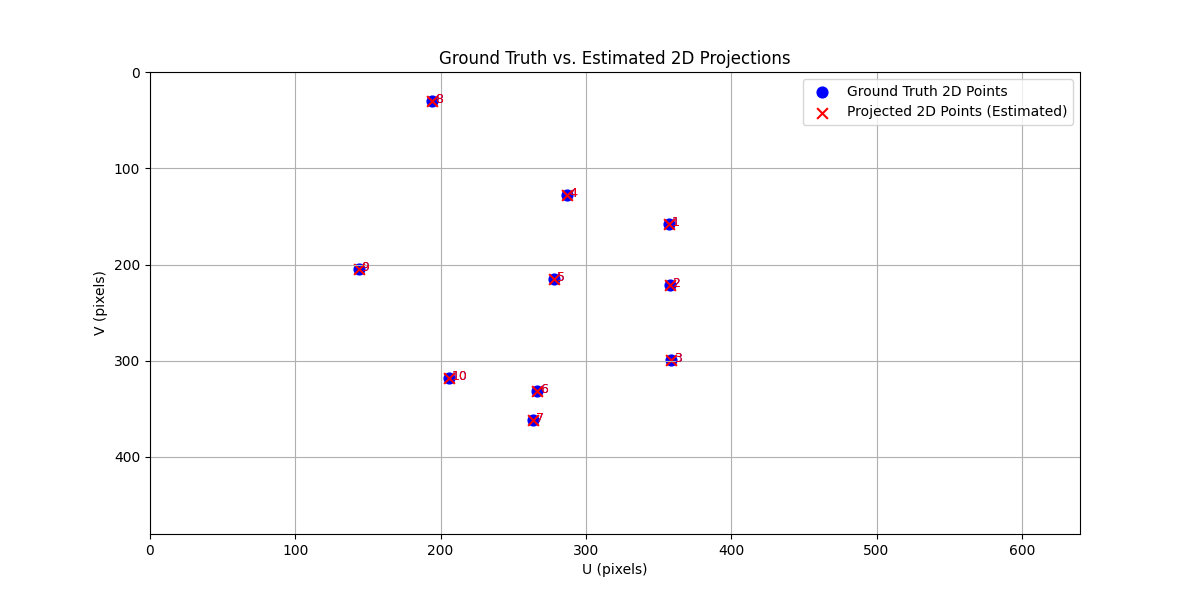

In [14]:
# ----- Step 1: Project the 3D world points -----
projected_points, _ = project_world_to_camera(world_3D_points, P_estimated_corrected, image_width, image_height)

# ----- Step 2: Adjust the y-axis sign to match the ground truth -----
# Flip the sign of the y-coordinate of the projected points
camera_pixel_2D_points[:, 1] = -camera_pixel_2D_points[:, 1]
print("Ground Truth 2D Points:")
print(camera_pixel_2D_points)

# ----- Step 3: Compute the Projection Error -----
# Compute the Euclidean distance between each projected point and its corresponding ground truth 2D point.
errors = np.linalg.norm(projected_points - camera_pixel_2D_points, axis=1)
mean_error = np.mean(errors)
print(f"Mean Projection Error (in pixels): {mean_error:.16f}")

# ----- Step 4: Plot the Ground Truth 2D Points vs. the Projected Points -----
plt.figure(figsize=(12, 6))
# Plot ground truth points (blue circles)
plt.scatter(camera_pixel_2D_points[:, 0], camera_pixel_2D_points[:, 1],
            color='blue', marker='o', label='Ground Truth 2D Points', s=60)
# Plot corrected projected points (red x's)
plt.scatter(projected_points[:, 0], projected_points[:, 1],
            color='red', marker='x', label='Projected 2D Points (Estimated)', s=60)

# Annotate the points by index (optional)
for i in range(len(camera_pixel_2D_points)):
    plt.text(camera_pixel_2D_points[i, 0] + 2, camera_pixel_2D_points[i, 1] + 2, str(i+1), color='blue', fontsize=9)
    plt.text(projected_points[i, 0] + 2, projected_points[i, 1] + 2, str(i+1), color='red', fontsize=9)

plt.xlabel('U (pixels)')
plt.ylabel('V (pixels)')
plt.title('Ground Truth vs. Estimated 2D Projections')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for proper image display
plt.grid(True)
# Set the full image dimensions for the axes
plt.xlim(0, 640)
plt.ylim(480, 0)  # Inverted y-axis for proper image display
plt.show()

### --------------------------
### Task-4 Estimating Camera Parameters with the world-points and 2-d points
### --------------------------

In [15]:
# For visualization, print the "captured" 2D points
print("\nSimulated Captured 2D Points (without noise):")
print(camera_pixel_2D_points)


Simulated Captured 2D Points (without noise):
[[356.94772311 157.78194854]
 [357.597318   221.73218083]
 [358.38558787 299.3344544 ]
 [286.85177204 127.8114991 ]
 [278.07377657 215.52191499]
 [266.47241801 331.44359531]
 [263.43872795 361.7564632 ]
 [194.39914449  30.27841578]
 [143.56243339 205.01746329]
 [205.82938765 318.22121282]]


In [16]:
# We add Gaussian noise to simulate errors in detecting marker positions.
# Adjusting standard deviation (sigma) to simulate different noise levels.
sigma = 5.0  # e.g., 5 pixels standard deviation
noise = np.random.normal(0, sigma, camera_pixel_2D_points.shape)
camera_pixel_2D_points_noisy = camera_pixel_2D_points + noise

print("\nSimulated Captured 2D Points (with noise):")
print(camera_pixel_2D_points_noisy)



Simulated Captured 2D Points (with noise):
[[361.2699041  154.07112343]
 [368.94609112 214.46035246]
 [358.61438046 298.39853515]
 [294.51566811 135.15829295]
 [278.8485137  217.41272759]
 [262.03348927 321.53961297]
 [261.6991672  362.53820805]
 [200.5505979   36.29031502]
 [141.6257993  203.50594954]
 [200.58662282 311.12112314]]


In [17]:
P_noisy_estimated = find_projection_matrix(world_3D_points, camera_pixel_2D_points_noisy)
if P_noisy_estimated[2, 3] < 0:
    P_noisy_estimated = -P_noisy_estimated
print("\nEstimated Projection Matrix (P_noisy_estimated):")
print(P_noisy_estimated)



Estimated Projection Matrix (P_noisy_estimated):
[[-612.63202505 -111.30690099 -267.21068162 4540.07150756]
 [  77.72732869  592.41288669 -210.44578641 1053.01263597]
 [   0.35719178   -0.08126919   -0.93048877   10.38773357]]


In [18]:
# (You can also decompose P_estimated if needed)
fx_est, fy_est, cx_est, cy_est, R_est, t_est, C_est = decompose_projection_matrix(P_noisy_estimated)
print("\nEstimated Camera Center (from decomposition):")
print(C_est)
print("Ground Truth Camera Center:")
print(camera_translation_vector_from_world_origin)


Estimated Camera Center (from decomposition):
[ 1.91476311  2.13198774 11.71256081]
Ground Truth Camera Center:
[ 2.  2. 12.]



Mean Projection Error (in pixels): 6.5443049493954835


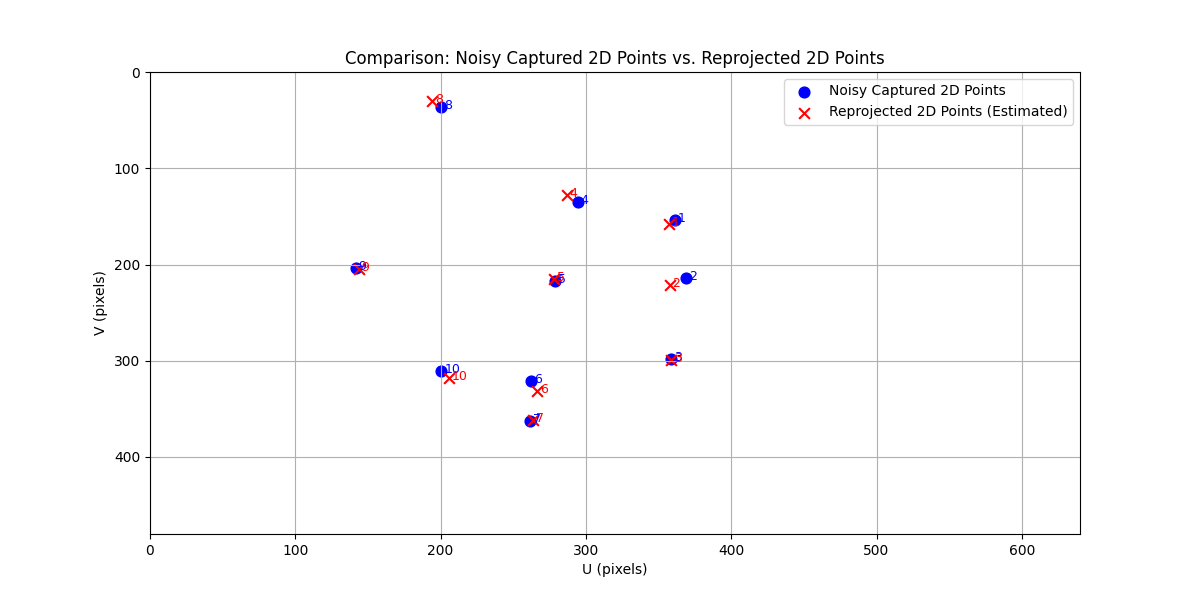

In [19]:
# Compute the projection error between the noisy image points and the reprojected points.
# (Here, we also invert the y for the noisy points for proper comparison.)
noisy_points_display = camera_pixel_2D_points_noisy.copy()
errors = np.linalg.norm(projected_points - noisy_points_display, axis=1)
mean_error = np.mean(errors)
print(f"\nMean Projection Error (in pixels): {mean_error:.16f}")

# Plot the results: Ground Truth (noisy "captured" points) vs. Reprojected Points from Estimated Matrix.
plt.figure(figsize=(12, 6))
plt.scatter(noisy_points_display[:, 0], noisy_points_display[:, 1],
            color='blue', marker='o', label='Noisy Captured 2D Points', s=60)
plt.scatter(projected_points[:, 0], projected_points[:, 1],
            color='red', marker='x', label='Reprojected 2D Points (Estimated)', s=60)
for i in range(len(noisy_points_display)):
    plt.text(noisy_points_display[i, 0] + 2, noisy_points_display[i, 1] + 2, str(i+1), color='blue', fontsize=9)
    plt.text(projected_points[i, 0] + 2, projected_points[i, 1] + 2, str(i+1), color='red', fontsize=9)
    
plt.xlabel('U (pixels)')
plt.ylabel('V (pixels)')
plt.title('Comparison: Noisy Captured 2D Points vs. Reprojected 2D Points')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for proper image display
plt.grid(True)
# Set the full image dimensions for the axes
plt.xlim(0, 640)
plt.ylim(480, 0)  # Inverted y-axis for proper image display
plt.show()